In [48]:
import os
import json
import urllib.request
import requests
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import shutil
import json
import random
import numpy as np
import cv2

## Data for Bottle Segmentation

For the bottle segmentation task, two primary datasets were utilized:

1. **COCO dataset**: This annotated dataset covers 80 object categories. The bottle category was specifically focused on for this project. 

2. **Plastic Segmentation Intel dataset**: This dataset was sourced from [Roboflow Universe](https://universe.roboflow.com/apu-jimbr/plastic-segmentation-intel). It offers additional data specifically tailored for plastic object segmentation, complementing the annotations from COCO. For this project, the bottle images were only used.

### Acquiring Data from COCO

To fetch bottle data from the COCO dataset, the `pycocotools` library was employed. The library offers a set of utilities tailored for the COCO dataset. Here's an overview of the steps followed:

1. **Initialization**: The COCO API was initialized by providing the path to the annotations.

    ```python
    from pycocotools.coco import COCO
    coco = COCO('./data/annotations/instances_train2017.json')
    ```

2. **Data Retrieval**: Once the COCO API was set up, data specifically related to bottles was retrieved. This ensured that only the relevant data was acquired for the project.


In [2]:
coco = COCO('./data/annotations/instances_train2017.json')

# Get the category ID for bottles
cat_id = coco.getCatIds(catNms=['bottle'])

# Get the image IDs for all images containing bottles
img_ids = coco.getImgIds(catIds=cat_id)

# Directory to save the bottle images
save_dir = './data/images/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
counter = 0

# Download the bottle images
for img_id in img_ids:
    img_data = coco.loadImgs(img_id)[0]
    img_name = os.path.basename(img_data['coco_url'])
    save_path = os.path.join(save_dir, img_name)
    
    # If image already exists, skip
    if os.path.exists(save_path):
        continue
    
    try:
        urllib.request.urlretrieve(img_data['coco_url'], save_path)
        
        counter += 1
        if (counter % 100 == 0):
            print(f"Downloaded {counter} images")
    except:
        print(f"Error downloading image ID {img_id}. Skipping...")

print(f"Downloaded {counter} bottle images to {save_dir}")

loading annotations into memory...
Done (t=36.92s)
creating index...
index created!
Downloaded 0 bottle images to ./dataset/images/


### Display some random images and their corresponding masks


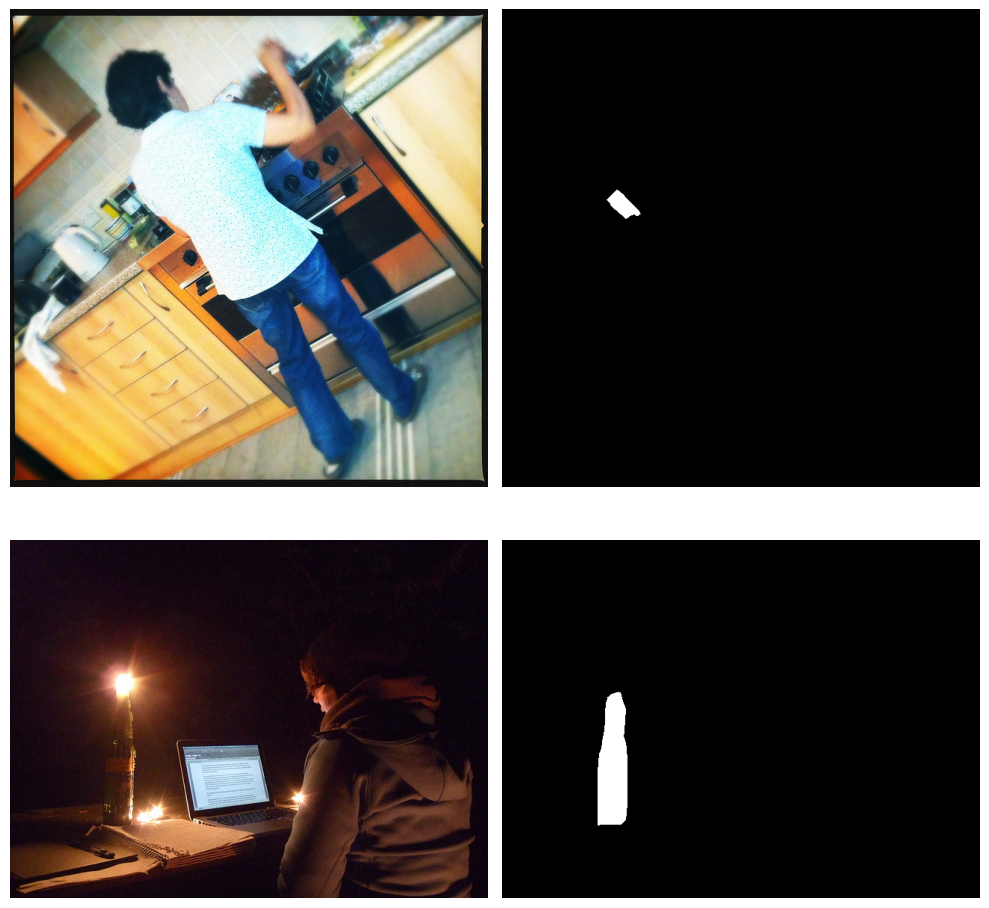

In [30]:
# List the image files
image_files = os.listdir('./data/images')
selected_files = random.sample(image_files, 2)

# Prepare figure for 2 images and 2 masks
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# For each selected image file, show the image and mask
for i, image_file in enumerate(selected_files):
    image_path = os.path.join('./data/images', image_file)
    image = plt.imread(image_path)
    img_id = int(image_file.split('.')[0])  # Extract image ID from filename
    
    # Get annotations for the selected image
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_id, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    
    mask = np.zeros_like(image[:, :, 0])
    for ann in anns:
        mask += mask_utils.decode(coco.annToRLE(ann))
    mask = np.where(mask > 0, 255, 0)  # Convert to binary mask
    
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


As can be seen above, some of the images containing bottles may be not as useful as others for our task. Therefore, we try to filter images where bottles occupy at least 10% of the image

In [31]:
filtered_img_ids = []

threshold = 0.10  # 10%

for img_id in img_ids:
    img_data = coco.loadImgs(img_id)[0]
    img_area = img_data['height'] * img_data['width']

    ann_ids = coco.getAnnIds(imgIds=img_data['id'], catIds=cat_id, iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    total_bottle_area = sum([ann['area'] for ann in anns])
    
    if total_bottle_area / img_area >= threshold:
        filtered_img_ids.append(img_id)

print(f"Number of images where bottles occupy at least {threshold*100}% of the image:", len(filtered_img_ids))


Number of images where bottles occupy at least 10.0% of the image: 482


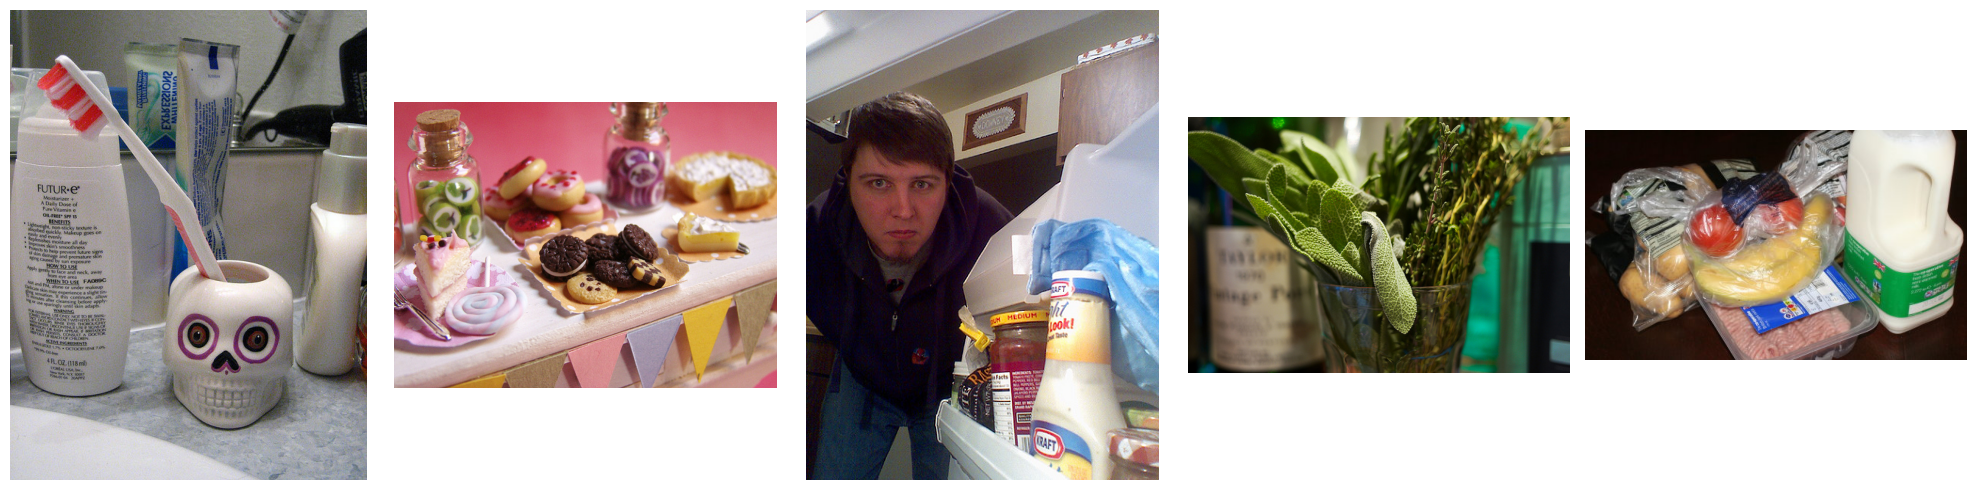

In [25]:
# Display some of these images

# Randomly select 5 image IDs
selected_img_ids = random.sample(filtered_img_ids, 5)

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for ax, img_id in zip(axs, selected_img_ids):
    img_data = coco.loadImgs(img_id)[0]
    img_url = img_data['coco_url']
    
    with urllib.request.urlopen(img_url) as response:
        image = plt.imread(response, format='jpg')
        ax.imshow(image)
        ax.axis('off')

plt.tight_layout()
plt.show()


### Load the annotations from the JSON file


In [32]:
with open('./data/annotations/instances_train2017.json', 'r') as f:
    data = json.load(f)

# Print the first annotation entry
first_annotation = data['annotations'][0]
print(first_annotation)

{'segmentation': [[239.97, 260.24, 222.04, 270.49, 199.84, 253.41, 213.5, 227.79, 259.62, 200.46, 274.13, 202.17, 277.55, 210.71, 249.37, 253.41, 237.41, 264.51, 242.54, 261.95, 228.87, 271.34]], 'area': 2765.1486500000005, 'iscrowd': 0, 'image_id': 558840, 'bbox': [199.84, 200.46, 77.71, 70.88], 'category_id': 58, 'id': 156}


In [33]:
# Print the first image's data
first_image = data['images'][0]
print(first_image)

{'license': 3, 'file_name': '000000391895.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg', 'height': 360, 'width': 640, 'date_captured': '2013-11-14 11:18:45', 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg', 'id': 391895}


### Copy the filtered images 

In [39]:
# Copy the images where bottles occupy at least 10.0% of the image

# Create a lookup for image ids to file names
img_id_to_filename = {x['id']: x['file_name'] for x in data['images']}

# Define the source and destination directories
src_dir = './data/images'
dst_dir = './data/coco_bottle_images'

# Ensure the destination directory exists
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

# Move the images
for img_id in filtered_img_ids:
    img_name = img_id_to_filename[img_id]
    src_path = os.path.join(src_dir, img_name)
    dst_path = os.path.join(dst_dir, img_name)
    # Copy the image
    shutil.copy(src_path, dst_path)  

print(f"copied {len(filtered_img_ids)} images to {dst_dir}")


copied 482 images to ./dataset/coco_bottle_images


### create new annotation file for these filtered images

In [40]:
# Filter the image entries
filtered_images = [img for img in data['images'] if img['id'] in filtered_img_ids]

# Collect ids of filtered images
filtered_image_ids_set = set([img['id'] for img in filtered_images])

# Filter the annotations
filtered_annotations = [ann for ann in data['annotations'] if ann['image_id'] in filtered_image_ids_set]

# Construct the new data structure
filtered_data = {
    "info": data['info'],
    "licenses": data['licenses'],
    "images": filtered_images,
    "annotations": filtered_annotations,
    "categories": data['categories']
}

# Save the filtered data to a new file
with open('./data/annotations/filtered_instances_train2017.json', 'w') as f:
    json.dump(filtered_data, f)

print(f"Saved the new annotations to './data/annotations/filtered_instances_train2017.json'")


Saved the new annotations to './dataset/annotations/filtered_instances_train2017.json'


In [57]:
# Initialize the new COCO API object
coco = COCO('./data/annotations/filtered_instances_train2017.json')

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [58]:
# After deleting some irrelevant images, create a new annotation file

# Load filtered annotations
with open('./data/annotations/filtered_instances_train2017.json', 'r') as f:
    original_data = json.load(f)

# Get the list of current image filenames in the coco_bottle_images directory 
current_images = [os.path.splitext(f)[0] for f in os.listdir('./data/coco_bottle_images') if f.endswith('.jpg')]

# Convert COCO image names to integers to match the IDs in annotations
current_image_ids = [int(img_name) for img_name in current_images]

# Filter the image data based on the current images
filtered_images = [img for img in original_data['images'] if img['id'] in current_image_ids]

# Get the IDs of the filtered images
filtered_image_ids = [img['id'] for img in filtered_images]

# Filter the annotations based on the filtered image IDs
filtered_annotations = [ann for ann in original_data['annotations'] if ann['image_id'] in filtered_image_ids]

# Update the original_data dictionary
original_data['images'] = filtered_images
original_data['annotations'] = filtered_annotations

# Save the new filtered annotations to a new file
with open('./data/annotations/updated_filtered_instances_train2017.json', 'w') as f:
    json.dump(original_data, f)

In [18]:
coco = COCO('./data/annotations/updated_filtered_instances_train2017.json')

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [19]:
# Load the JSON file
with open("./data/annotations/updated_filtered_instances_train2017.json", "r") as f:
    data = json.load(f)

The Image sizes are differnt. In the following cell they will be resized to have the same size.

In [ ]:
# Resize the images to 640*640
image_directory = './data/coco_bottle_images/'

for filename in os.listdir(image_directory):
    if filename.endswith('.jpg') or filename.endswith('.png'): 
        image_path = os.path.join(image_directory, filename)
        img = Image.open(image_path)
        img_resized = img.resize((640, 640))
        img_resized.save(image_path)

Changing the image size affects the coordinates of bounding boxes and segmentation annotations. This changes should be applied to the annotation file.

In [72]:
# Create new annotation file for the resized images

# Create a dictionary to store image_id -> (width, height)
img_dims = {img["id"]: (img["width"], img["height"]) for img in data["images"]}

NEW_WIDTH = 640
NEW_HEIGHT = 640

for ann in data["annotations"]:
    # Fetch the old dimensions
    old_width, old_height = img_dims[ann["image_id"]]
    
    # Calculate the scaling factors
    width_scale = NEW_WIDTH / old_width
    height_scale = NEW_HEIGHT / old_height

    # Bounding box rescaling
    old_bbox = ann["bbox"]
    
    ann["bbox"] = [
        old_bbox[0] * width_scale,       # x-coordinate
        old_bbox[1] * height_scale,      # y-coordinate
        old_bbox[2] * width_scale,       # width
        old_bbox[3] * height_scale       # height
    ]
    
    # Update segmentation
    try:
        new_seg = []
        for seg_list in ann["segmentation"]:
            updated_list = []
            for i in range(0, len(seg_list), 2):  # Processing (x, y) pairs
                updated_list.append(float(seg_list[i]) * width_scale)    # x-coordinate
                updated_list.append(float(seg_list[i+1]) * height_scale)  # y-coordinate
            new_seg.append(updated_list)
        ann["segmentation"] = new_seg
    except Exception as e:
        print(f"Problem with image ID {ann['image_id']} - skipping. Error: {e}")
        
# Update image dimensions
for img in data['images']:
    img['width'] = NEW_WIDTH
    img['height'] = NEW_HEIGHT
    
# Save the modified data back to a new JSON file
with open("./data/annotations/resized_filtered_instances_train2017.json", "w") as f:
    json.dump(data, f)

print("Annotations updated and saved to resized_filtered_instances_train2017.json")


Problem with image ID 80953 - skipping. Error: could not convert string to float: 'c'
Problem with image ID 8876 - skipping. Error: could not convert string to float: 'c'
Problem with image ID 48908 - skipping. Error: could not convert string to float: 'c'
Annotations updated and saved to resized_filtered_instances_train2017.json


### Load the final annotation file

In [3]:
# Initialize the COCO object
coco = COCO('./data/annotations/resized_filtered_instances_train2017.json')
cat_id = coco.getCatIds(catNms=['bottle'])
# Load the JSON file
with open("./data/annotations/resized_filtered_instances_train2017.json", "r") as f:
    data = json.load(f)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!


#### Display some images and their masks

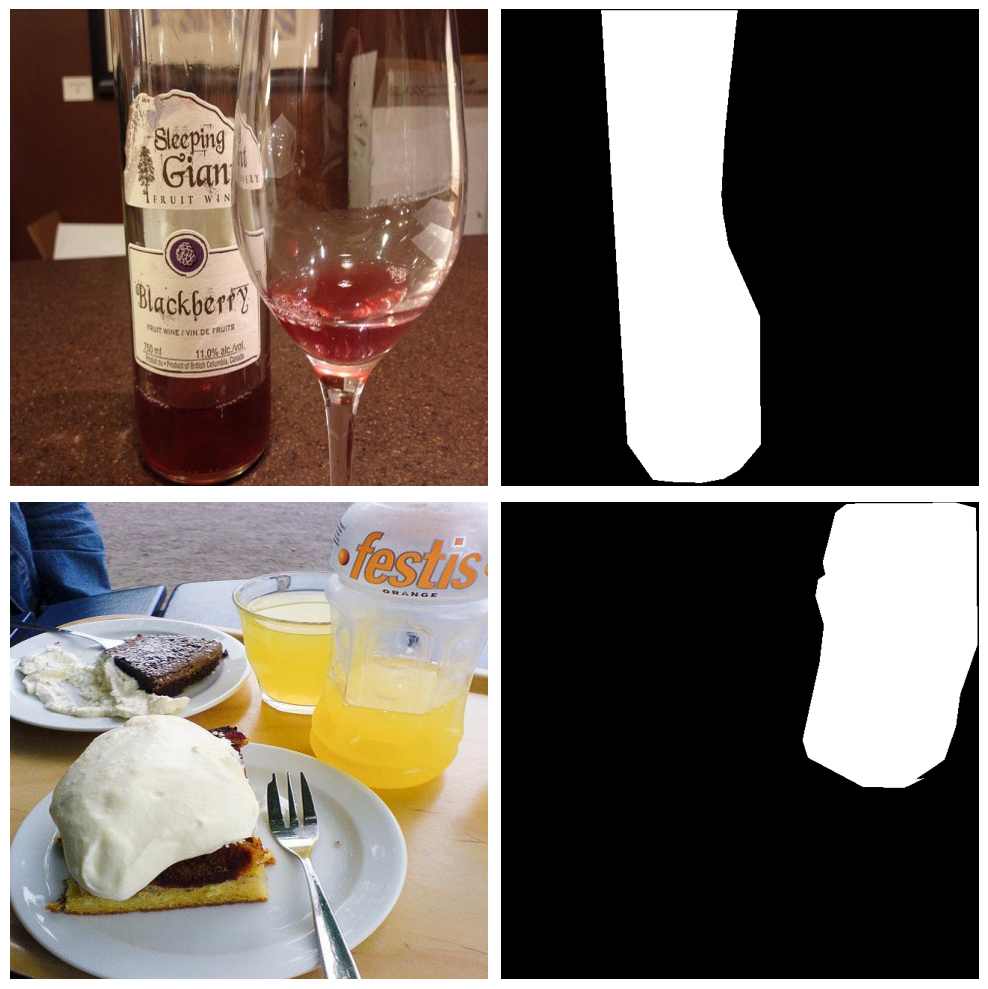

In [4]:
# List the image files
image_files = os.listdir('./data/coco_bottle_images')

selected_files = random.sample(image_files, 2)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# For each selected image file, show the image and mask
for i, image_file in enumerate(selected_files):
    image_path = os.path.join('./data/coco_bottle_images', image_file)
    image = plt.imread(image_path)
    img_id = int(image_file.split('.')[0])  # Extract image ID from filename
    
    # Get annotations for the selected image
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_id, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    
    mask = np.zeros_like(image[:, :, 0])
    for ann in anns:
        mask += mask_utils.decode(coco.annToRLE(ann))
    mask = np.where(mask > 0, 255, 0)  # Convert to binary mask
    
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    axs[i, 1].imshow(mask, cmap='gray')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


### Save coco bottle masks 

In [ ]:
cat_id = coco.getCatIds(catNms=['bottle'])
img_ids = coco.getImgIds(catIds=cat_id)

for img_id in img_ids:
    img = coco.loadImgs(img_id)[0]
    ann_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_id, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    
    mask_combined = np.zeros((img['height'], img['width']), dtype=np.uint8)
    for ann in anns:
        mask_ann = mask_utils.decode(coco.annToRLE(ann))
        if mask_ann.shape == mask_combined.shape:
            mask_combined += mask_ann

    mask_combined = np.where(mask_combined > 0, 255, 0)  # Convert to binary mask
    
    # save the mask 
    mask_path = os.path.join('./data/coco_bottle_masks', img['file_name'])
    cv2.imwrite(mask_path, mask_combined)

---

## Merge images and masks from both datasets
The selected data from the COCO dataset is now prepared for use. Before proceeding with the model training, data (both images and masks) from the Plastic Segmentation Intel dataset needs to be integrated with the current dataset. Initially, this data will be stored in the 'images_src' and 'masks_src' directories. Subsequently, the data will be shuffled and partitioned into training and validation sets.

---

In [ ]:
# Source directory paths
images_src = './data/images_src'
masks_src = './data/masks_src'
# Destination paths
images_dest_train = './data/train/plastic_bottle_images'
masks_dest_train = './data/train/plastic_bottle_masks'
images_dest_val = './data/val/plastic_bottle_images'
masks_dest_val = './data/val/plastic_bottle_masks'

# Create directories if they don't exist
os.makedirs(images_dest_train, exist_ok=True)
os.makedirs(masks_dest_train, exist_ok=True)
os.makedirs(images_dest_val, exist_ok=True)
os.makedirs(masks_dest_val, exist_ok=True)

# List of all image and mask files
image_files = [f for f in os.listdir(images_src) if os.path.isfile(os.path.join(images_src, f))]
mask_files = [f for f in os.listdir(masks_src) if os.path.isfile(os.path.join(masks_src, f))]

# Shuffle images
random.shuffle(image_files)

# Split ratio
split_ratio = 0.1  # 10% for validation
split_idx = int(len(image_files) * split_ratio)

# Split data into train and val sets
val_files = image_files[:split_idx]
train_files = image_files[split_idx:]

# Move files
for f in train_files:
    shutil.move(os.path.join(images_src, f), os.path.join(images_dest_train, f))
    shutil.move(os.path.join(masks_src, f), os.path.join(masks_dest_train, f))

for f in val_files:
    shutil.move(os.path.join(images_src, f), os.path.join(images_dest_val, f))
    shutil.move(os.path.join(masks_src, f), os.path.join(masks_dest_val, f))
